<a href="https://colab.research.google.com/github/AndrewstheBuilder/FromScratch_NeuralNetworks/blob/main/MultiLayerPerceptron_FromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

import copy

np.random.seed(1)

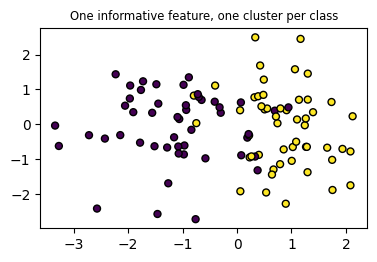

In [3]:
# Display Dataset to Train

plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

plt.subplot(321)
plt.title("One informative feature, one cluster per class", fontsize="small")
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1
)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")

# Import Dataset to Train
train_length = int(len(X1) * 0.8)
test_length = len(X1) - train_length
train_x, test_x, train_y, test_y = X1[0:train_length], X1[train_length:], Y1[0:train_length], Y1[train_length:]
# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

In [187]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        # print('__add__ self',self)
        # print('__add__ other',other)
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # print('out',out)

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(x):
      if(x.data<=0):
        return Value(0)
      return Value(1)

    # def relu(self):
    #     out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    #     def _backward():
    #         self.grad += (out.data > 0) * out.grad
    #     out._backward = _backward

    #     return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [190]:
# Multi Layer Perceptron Implementation
class Neuron:
  '''
  '''
  def __init__(self, nin, nonlin=True):
        self.w = [Value(value)for value in np.random.randn(nin)]
        self.b = Value(np.random.randn(1))
        self.nonlin = nonlin

  def __call__(self, x):
      act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
      return act.relu() if self.nonlin else act

  def parameters(self):
      return self.w + [self.b]

  def __repr__(self):
      return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

  def backward(self,x,error,lr=0.001):
    '''
    Define Neuron's backward as Perceptron convergence theorem
    '''
    for i in range(len(self.w)):
        self.w[i] += x[i]*lr*error
    self.b += lr*error

In [186]:
w = Value(10)
w += 1.5 * 3.3 * 5.2
x = Value(10)
x += Value(1.5) * Value(3.3) * Value(5.2)

__add__ self Value(data=10, grad=0)
__add__ other 25.74
out Value(data=35.739999999999995, grad=0)
__add__ self Value(data=10, grad=0)
__add__ other Value(data=25.74, grad=0)
out Value(data=35.739999999999995, grad=0)


# First Attempt at solving this dataset with a Multi-Layer Perceptron(MLP)(turned into just being Perceptron)

- I can attempt to solve this as a regression problem first
- Take in X and try to predict the Y for the 100 examples of [Xi, Yi] that I have. It will find the line separating the two classes I believe!
- And after that I can try it as a classification problem.
- Then solve the MNIST dataset with my MLP
- Then try to do it with a different architecture like KANs

### Draft 1 **Perceptron**: Has backpropagation for learning but its adjusting the weights and biases without taking into account the error and what direction we should be adjusting the weights in.
- This setup allows the ML algorithm to learn any linear 2 variable function.

In [5]:
# Initialize weights start with the same values
weights = [1,1]
bias = 1

def relu(x):
  # if(x<=0):
  #   return 0
  # return 1
  return max(0, x)

def relu_deriv(output_relu):
  if(output_relu>=0):
    return 1
  return 0

weights = [1,1]
bias = 1
# n = Neuron(weights, None)
m = len(train_x)
iterations = 500
for n in range(iterations):
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2+ bias
    # Perform Loss Calculation
    error = (train_y[i] - output)
    # print('train_y[i]',train_y[i])
    # print('output',output)
    # Perform Back propagation to adjust the weight and bias
    weights[0] += -1 * x1
    weights[1] += -1 * x2
    bias += -1
  if(n%100 == 0):
    print('n:'+str(n)+' error:'+str(error))
# print(n)
# This implementation has the problem of exploding weights.
# I believe its because we are not taking into account the error. So we are adjusting
# the weight in the wrong direction

n:0 error:81.22777519106502
n:100 error:8514.92376252429
n:200 error:16948.619749857513
n:300 error:25382.315737190816
n:400 error:33816.011724524156


### Draft 2 **Perceptron**: There is no breaking symmetry here because the weights start out at the same value. But we introduce relu activation and use the error and learning rate to determine which direction and how much to adjust the weights and bias by.
- With a bias the weights start to cancel each other out and the bias starts to dominate the output
- Without a bias the weights find a equilibrium that leds to a inefficient solution. Its stuck in a pit. Forgot what this concept is called...

In [6]:
# Initialize weights start with the same values
weights = [1,1]
bias = 1

def relu(x):
  # if(x<=0):
  #   return 0
  # return 1
  return max(0, x)

def relu_deriv(output_relu):
  if(output_relu>=0):
    return 1
  return 0

m = len(train_x)
print('len(train_x)',m)
iterations = 500
lr = 0.001
for n in range(iterations):
  correct = 0
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2 + bias
    output_relu = relu(output)
    # Perform Loss Calculation
    error = (train_y[i] - output_relu)
    # print('error',error)
    if(error<0.5 and error > -0.5):
      correct += 1
    # Perform Back propagation to adjust the weight and bias
    weights[0] -= -1 * relu_deriv(output_relu) * x1 * lr * error
    weights[1] -= -1 * relu_deriv(output_relu) * x2 * lr * error
    bias += -1 * relu_deriv(output_relu) * lr * error
  if(n%10 == 0):
    print('----'*10)
    print('At the end of iteration:')
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',weights)
    print('bias',bias)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)
    # print('----'*10)
# print(n)

len(train_x) 80
----------------------------------------
At the end of iteration:
n:0 Train Accuracy:0.4375
weights [0.971292552005344, 0.9535162971189877]
bias 1.048295544994018
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  1.7192174804240021
----------------------------------------
At the end of iteration:
n:10 Train Accuracy:0.25
weights [0.7101281000860064, 0.556590881439778]
bias 1.6920795977228704
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  2.0264792373089793
----------------------------------------
At the end of iteration:
n:20 Train Accuracy:0.0
weights [0.6025945323405167, 0.31056296971150343]
bias 3.0098949433044617
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  3.1142457987897276
----------------------------------------
At the end of iteration:
n:30 Train Accuracy:0.0
weights [0.7705604028534646, 0.22149380188570253]
bias 5.929104061242038
Sample input [-0.40147619  1.11

### Draft 3 **Perceptron**: Introducing Breaking Symmetry
* By initializing weights and bias randomly
* It seems like now the bias has grown to cancel out the weights contribution. Its not immediately clear what breaking the symmetry has done. I wonder how they discovered this concept...

In [7]:
def relu(x):
  # if(x<=0):
  #   return 0
  # return 1
  return max(0, x)

def relu_deriv(output_relu):
  if(output_relu>=0):
    return 1
  return 0

# Initialize weights
np.random.seed(1)
weights = np.random.randn(2,)
bias = np.random.randn(1)[0]

m = len(train_x)
print('len(train_x)',m)
iterations = 6000
lr = 0.001
points = []
predicted = []
for n in range(iterations):
  correct = 0
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2 + bias
    output_relu = relu(output)
    # Perform Loss Calculation
    error = (train_y[i] - output_relu)
    # print('error',error)
    if(error<0.5 and error > -0.5):
      correct += 1
    if(n == iterations-1):
      points.append(train_x[i])
      predicted.append(output_relu)
        # correct_points.append(train_x[i])
        # print('correct_points after',correct_points)
        # print('train_x[i]',train_x[i])
    # Perform Back propagation to adjust the weight and bias
    weights[0] -= -1 * relu_deriv(output_relu) * x1 * lr * error
    weights[1] -= -1 * relu_deriv(output_relu) * x2 * lr * error
    bias += -1 * relu_deriv(output_relu) * lr * error
  if(n%2000 == 0 or n == iterations-1):
    print('----'*10)
    print('At the end of iteration:')
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',weights)
    print('bias',bias)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)
    # print('----'*10)
points = np.array(points)
predicted = np.array(predicted)
# print(n)
# print('correct_points',correct_points)
# print('np.array(correct_points)',np.array(correct_points))

len(train_x) 80
----------------------------------------
At the end of iteration:
n:0 Train Accuracy:0.625
weights [ 1.60183805 -0.58643642]
bias -0.5249619716511665
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -1.8207473119361808
----------------------------------------
At the end of iteration:
n:2000 Train Accuracy:0.5375
weights [30.92770354  0.70496574]
bias -61.95679602366454
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -73.58980504940439
----------------------------------------
At the end of iteration:
n:4000 Train Accuracy:0.5375
weights [60.29344926  0.17701524]
bias -123.89848441948818
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -147.9083751256071
----------------------------------------
At the end of iteration:
n:5999 Train Accuracy:0.5375
weights [89.61284315 -0.41646986]
bias -185.80176929525513
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 

In [8]:
print('train_x[:,0]',train_x[0])
# The first point train_x[0][0] is x in plt.scatter so when I solved for y
  # in y = mx+b y is train_x[:,1]
  # this affects if I divide weights[0]/weights[1] for m or weights[1]/weights[0]

train_x[:,0] [-0.97549005 -0.85611091]


predicted [0.         1.55310025 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         4.30991835 0.         0.
 0.         0.         1.16788956 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
f(x) = w1*x1 + w2*x2 + b
f(x) = 89.61284314510445*x1 + -0.4164698582742479*x2 + -185.80176929525513


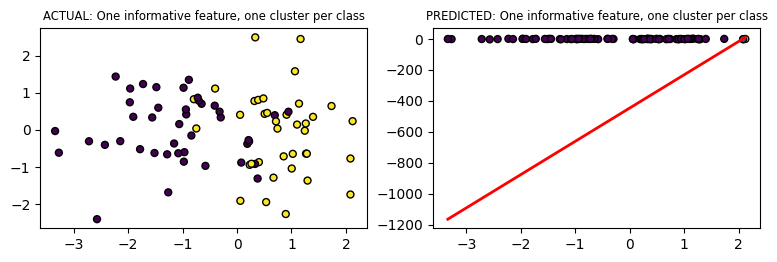

In [9]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Subplot for train data (Top Left)
plt.subplot(3, 2, 1)  # Use subplot grid (3 rows, 2 columns, position 1)
plt.title("ACTUAL: One informative feature, one cluster per class", fontsize="small")
plt.scatter(train_x[:, 0], train_x[:, 1], marker="o", c=train_y, s=25, edgecolor="k")

# Subplot for predicted data (Top Right)
plt.subplot(3, 2, 2)  # Use subplot grid (3 rows, 2 columns, position 2)
plt.title("PREDICTED: One informative feature, one cluster per class", fontsize="small")
plt.scatter(points[:, 0], points[:, 1], marker="o", c=predicted, s=25, edgecolor="k")

# Assuming the equation is y = mx + b (obtained from the model)
# Define range of x-values (adjust based on your data)
x_range = np.linspace(min(points[:, 0]), max(points[:, 0]), 100)
# Calculate predicted y-values for the range
predicted_y = -(weights[0]/weights[1]) * x_range - (bias/ weights[1])
# Overlay the line on the predicted data scatter plot
plt.plot(x_range, predicted_y, color='red', linewidth=2)

print('predicted',predicted)
print('f(x) = w1*x1 + w2*x2 + b')
print('f(x) = '+str(weights[0])+'*x1 + '+str(weights[1])+'*x2 + ' + str(bias))
# print('points.shape',points.shape)
# print('predicted.shape',predicted.shape)
# print('train_x.shape',train_x.shape)
# print('train_y.shape',train_y.shape)


# TODO COMPLETED: draw last iteration MLP predictions on training set on graph stopped here
  # I want to see the function that its learning
  # Since the function that my network is able to learn is linear it does not look like
  # it can learn what is displayed on the graph
  # equation is f(x) = w1*x1 + w2*x2 + b

### Draft 4 New and Improved **Perceptron**: 100% on test set!!
* Since its a Perceptron I couldn't use back prop it didn't work effectively for some reason?? I had to use the Perceptron Convergence Theorem.
  - Investigate why back prop does not work for Perceptrons?

In [199]:
def relu(x):
  if(x<=0):
    return 0
  return 1

# Parameter Initialization
np.random.seed(1)
weights = np.random.randn(2,)
bias = np.random.randn(1)[0]

# Training
m = len(train_x)
print('len(train_x)',m)
iterations = 300
lr = 0.001
points = []
predicted = []
raw_predicted = []
weights_changed = []
bias_changed = []
accuracy = []
for n in range(iterations):
  correct = 0
  for i in range(m):
    x1 = train_x[i][0]
    x2 = train_x[i][1]
    output = weights[0]*x1 + weights[1]*x2 + bias
    output_relu = relu(output)
    # Perform Loss Calculation
    error = (train_y[i] - output_relu)
    raw_predicted.append(output)
    # predicted.append(output_relu)
    if(error<0.5 and error > -0.5):
      correct += 1
    if(n == iterations-1):
      points.append(train_x[i])
      predicted.append(output_relu)
    # Perform Perceptron Convergence Theorem for Learning
    # Instead of backpropagation!
    weights[0] += lr*error *x1
    weights[1] += lr*error *x2
    bias += lr*error
    if(error != 0):
      weights_changed.append(copy.deepcopy(weights))
      bias_changed.append(bias)
  accuracy.append(correct/m)
  if(n%20== 0 or n == iterations-1):
    # print('error',error)
    print('weights',weights)
    print('----'*10)
    print('At the end of iteration:')
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',weights)
    print('bias',bias)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)

points = np.array(points)
predicted = np.array(predicted)


len(train_x) 80
weights [-0.2156566   1.44757064]
----------------------------------------
At the end of iteration:
n:0 Train Accuracy:0.5125
weights [-0.2156566   1.44757064]
bias -2.0291407094976575
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -0.33484032710903056
weights [0.35722582 1.22725008]
----------------------------------------
At the end of iteration:
n:20 Train Accuracy:0.575
weights [0.35722582 1.22725008]
bias -1.353140709497732
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -0.13389924454265412
weights [0.73356075 0.96074116]
----------------------------------------
At the end of iteration:
n:40 Train Accuracy:0.6875
weights [0.73356075 0.96074116]
bias -0.7971407094977706
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  -0.025423863841412597
weights [0.88390801 0.66515835]
----------------------------------------
At the end of iteration:
n:60 Train Accuracy:0.7875
weigh

weights_changed [ 1.62365193 -0.61215082]
[ 1.28195006 -0.01219284]
bias_changed
-0.5291717522634557
-0.2881717522634555
length of predicted 8000


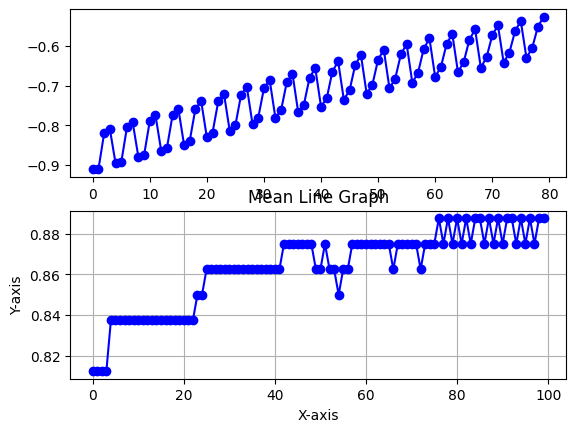

In [84]:
print('weights_changed', weights_changed[0])
print(weights_changed[len(weights_changed)-1])
print('bias_changed')
print(bias_changed[0])
print(bias_changed[len(bias_changed)-1])
print('length of predicted',len(raw_predicted))

x = list(range(80))
y = [np.mean(raw_predicted[i:i+100]) for i in range(0, len(raw_predicted), 100)]

# Create the plot
plt.subplot(2,1,1)
# plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b')

plt.subplot(2,1,2)
x = list(range(100))
plt.plot(x, accuracy, marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Mean Line Graph')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.grid(True)
plt.show()

In [85]:
# Test on test set
m_test = len(test_x)
correct=0
for i in range(m_test):
  x1 = test_x[i][0]
  x2 = test_x[i][1]
  output = weights[0]*x1 + weights[1]*x2 + bias
  output_relu = relu(output)
  # Perform Loss Calculation
  error = (test_y[i] - output_relu)
  # print('error',error)
  if(error<0.5 and error > -0.5):
    correct += 1
print(str(correct/m_test))

1.0


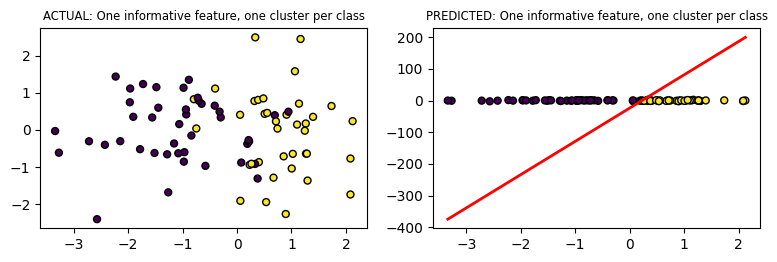

predicted_y [-374.7366545  -368.93611394 -363.13557337 -357.33503281 -351.53449224
 -345.73395168 -339.93341111 -334.13287054 -328.33232998 -322.53178941
 -316.73124885 -310.93070828 -305.13016771 -299.32962715 -293.52908658
 -287.72854602 -281.92800545 -276.12746488 -270.32692432 -264.52638375
 -258.72584319 -252.92530262 -247.12476205 -241.32422149 -235.52368092
 -229.72314036 -223.92259979 -218.12205922 -212.32151866 -206.52097809
 -200.72043753 -194.91989696 -189.11935639 -183.31881583 -177.51827526
 -171.7177347  -165.91719413 -160.11665357 -154.316113   -148.51557243
 -142.71503187 -136.9144913  -131.11395074 -125.31341017 -119.5128696
 -113.71232904 -107.91178847 -102.11124791  -96.31070734  -90.51016677
  -84.70962621  -78.90908564  -73.10854508  -67.30800451  -61.50746394
  -55.70692338  -49.90638281  -44.10584225  -38.30530168  -32.50476111
  -26.70422055  -20.90367998  -15.10313942   -9.30259885   -3.50205828
    2.29848228    8.09902285   13.89956341   19.70010398   25.5006

In [96]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=0.05, top=0.9, left=0.05, right=0.95)

# Subplot for train data (Top Left)
plt.subplot(3, 2, 1)  # Use subplot grid (3 rows, 2 columns, position 1)
plt.title("ACTUAL: One informative feature, one cluster per class", fontsize="small")
plt.scatter(train_x[:, 0], train_x[:, 1], marker="o", c=train_y, s=25, edgecolor="k")

# Subplot for predicted data (Top Right)
plt.subplot(3, 2, 2)  # Use subplot grid (3 rows, 2 columns, position 2)
plt.title("PREDICTED: One informative feature, one cluster per class", fontsize="small")
plt.scatter(points[:, 0], points[:, 1], marker="o", c=predicted, s=25, edgecolor="k")

# Assuming the equation is y = mx + b (obtained from the model)
# Overlay the line on the predicted data scatter plot
x_range = np.linspace(min(points[:, 0]), max(points[:, 0]), 100)
predicted_y = -(weights[0]/weights[1]) * x_range - (bias/ weights[1])
plt.plot(x_range, predicted_y, color='red', linewidth=2)
plt.show()
print('predicted_y',predicted_y)

# print('predicted',predicted)
print('f(x) = w1*x1 + w2*x2 + b')
print('f(x) = '+str(weights[0])+'*x1 + '+str(weights[1])+'*x2 + ' + str(bias))

### Draft 5 Perceptron Implemented using Micrograd framework
* Same as draft 4 but using Neuron and Value implementations from Micrograd

In [196]:
# Parameter Initialization
np.random.seed(1)
nn = Neuron(nin=train_x[1].shape[0])

# Training
m = len(train_x)
print('len(train_x)',m)
iterations = 300
points = []
predicted = []

for n in range(iterations):
  correct = 0
  for i in range(m):
    output = nn(train_x[i])
    # output = weights[0]*x1 + weights[1]*x2 + bias
    # output_relu = relu(output)

    # Perform Loss Calculation
    # print('output',output)
    # print('train_y[i]',train_y[i])
    error = (train_y[i] - output)
    # print('error',error)
    # print('error',error)
    # raw_predicted.append(output)
    # predicted.append(output_relu)
    if(error.data<0.5 and error.data > -0.5):
      correct += 1
    if(n == iterations-1):
      points.append(train_x[i])
      predicted.append(output.data)

    # Perform Backward()
    nn.backward(train_x[i],error.data)
    # error.backward()
    # weights[0] += lr*error *x1
    # weights[1] += lr*error *x2
    # bias += lr*error

  if(n%20 == 0 or n == iterations-1):
    print('----'*10)
    print('At the end of iteration:')
    print('error',error)
    print('n:'+str(n)+' Train Accuracy:'+str(correct/m))
    print('weights',nn.w)
    print('bias',nn.b)
    print('Sample input',train_x[m-1])
    print('Sample output f(x)=w1*x1 + w2*x2 + b --> ',output)

points = np.array(points)
predicted = np.array(predicted)


len(train_x) 80
----------------------------------------
At the end of iteration:
error Value(data=1, grad=0)
n:0 Train Accuracy:0.8125
weights [Value(data=1.6225393344076111, grad=0), Value(data=-0.5994057510557769, grad=0)]
bias Value(data=[-0.52517175], grad=0)
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  Value(data=0, grad=0)
----------------------------------------
At the end of iteration:
error Value(data=1, grad=0)
n:20 Train Accuracy:0.8375
weights [Value(data=1.5698076758068025, grad=0), Value(data=-0.40038879470525285, grad=0)]
bias Value(data=[-0.46517175], grad=0)
Sample input [-0.40147619  1.1122896 ]
Sample output f(x)=w1*x1 + w2*x2 + b -->  Value(data=0, grad=0)
----------------------------------------
At the end of iteration:
error Value(data=1, grad=0)
n:40 Train Accuracy:0.8625
weights [Value(data=1.5078001278493387, grad=0), Value(data=-0.23923885639444467, grad=0)]
bias Value(data=[-0.40317175], grad=0)
Sample input [-0.40147619  

## Using existing SKlearn MLP Implementation

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(1,)).fit(train_x, train_y)

In [ ]:
clf.score(test_x, test_y)

0.45

In [ ]:
clf.predict(test_x)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print('test_y',test_y)

test_y [1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0]
